In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython
import numpy as np

In [3]:
%matplotlib inline

In [4]:
import os

modelname="5_19_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 d_model: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 ff_scalar: int = 2):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, d_model)
        #Positional encoding
        self.pos_encode = PositionalEncoding(d_model)

        self.decoder_layers = []
        
        bottleneck_size = d_model
        ff_size = ff_scalar*bottleneck_size

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(d_model, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            #Add bottleneck layer
            layer.append(nn.Linear(d_model, ff_size))
            #Now add bottleneck layer norm
            layer.append(nn.LayerNorm(ff_size))
            #Add feed forward
            layer.append(nn.Linear(ff_size, d_model))
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            
            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(d_model, n_features)
        
        
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_bottleneck = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            d_ff = decoder_layer[4]
            d_layer_norm_3 = decoder_layer[5]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)
            
            #do bottleneck
            res = d_bottleneck(res)
            #layer norm
            res = d_layer_norm_2(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_3(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0, split: str = "\n"):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte
        self.split = split

    def tokenize_str(self, sentence: str, encoding = "utf8") -> torch.Tensor:
        base = [int(i) for i in bytes(sentence, encoding)]
        if len(base) < self.n_pad:
            base.extend([self.pad_byte] * (self.n_pad - len(base)))
        assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding = "utf8") -> torch.Tensor:
        # tokenize the input text
        sentences = []
        for sentence in texts:
            sentences.append(self.tokenize_str(sentence).unsqueeze(0))

        return torch.cat(sentences, dim = 0).to(self.device)
    
    @staticmethod
    def prepare_texts(document: str) -> typing.List[str]:
        return filter(lambda x: len(x)!=0, document.split(self.split))
    
    def sequences_to_texts(self, texts: torch.Tensor, encoding = "utf8") -> typing.List[str]:
        out = []
        for seq in texts:
            chars = []
            i=0
            while i<len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i+=1
            out.append(bytes(chars).decode(encoding, "replace"))
        return out

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], n_pad):
        self.raw_data = data
        self.tokenizer = Tokenizer(n_pad, device, split = "\0")
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return self.tokenizer.tokenize_str(self.raw_data[index])

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode("utf8","replace")

In [14]:
class WarmupScheduler:
    def __init__(self, duration, start_factor):
        self.duration = duration
        self.start_factor = start_factor
        self.factors = np.linspace(0, 1 - self.start_factor, duration)
        self.step = 0

    def get_lr_factor(self):
        if self.step >= self.duration:
            return 1
        res = self.factors[self.step] + self.start_factor
        self.step += 1
        return res

In [15]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 768
batch_size = 32
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
print(f"Head size: {head_size}")
n_layers = 12
BATCH_STEP_SIZE = 8

Head size: 12


In [16]:
path_to_data = "data/reddit_scrape_v4.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

51454


In [17]:
model = Transformer(d_model = embedding_dim, n_self_heads = head_size, n_features = n_features, n_layers = n_layers)
model=model.to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{count_parameters(model):,}", "trainable params")

57,154,816 trainable params


In [19]:
input=next(testloader_iter)
input=input.to(device)
print(input.shape)
res = model(input)
print(res.shape)

torch.Size([1, 512])
torch.Size([1, 512, 256])


In [20]:
lr = 4e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
warmup_sched = WarmupScheduler(5000, 0.01)

In [21]:
n_epochs = 40

In [22]:
!nvidia-smi

Fri May 19 21:10:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   56C    P0    64W / 150W |   1708MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
print(device)

cuda


In [24]:
prompts = [
    "Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.",
    "Hello world, ",
    "How to use ChatGPT? How should I use ChatGPT?",
    "My code does not work. What should I do? I have been working on my code, and it does not work.",
    "Why is this code not working: `1+\"A\"`? Can you help?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?",
    "What is coding?",
]

Epoch 1


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. the t the an an an an at at an t t t athe t t t t at t the t t t t at t t t t the t t an t t t an at at the t an an t t t the an an an t t t t t t t t t at t t t t t t t t t t t t the an an at athe t an at t an t t athe the t t the the t the an the t the an t t the an the athe the at t t an an an the athe the an an an an the at t an an athe an t the an athe t t the an an the the an ang ang ang ang the the the an an t an the the the an athe t an an the an t an the t the the an the the the an an an an an the the an t an the an an ang an an an the the the the the an ang the an t t the an an an an an athe the an an ang an t t athe the the the the an t the the t the the the athe t the the the the the the the the the t t the the t t

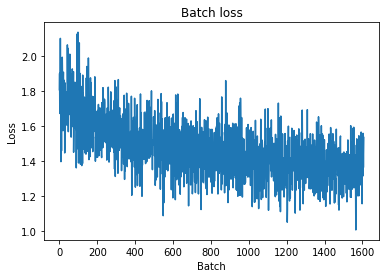

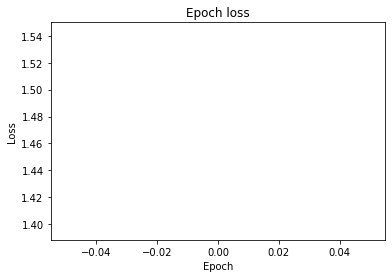

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. t t t the an t t an t the t t the the the t the t at t the t t t the t t an t the the an t the athe an t t the an t t t the t an t an an the t at t t the athe t t t the t t at the the athe t t t t at at athe the t athe t the the the the at athe t t t the an the at an an the at t an t t an t an an the an t t t t the an the the an t an an t at the the the t the the the t the an the an ang an an ang an t athe the an the ang the t the the an at an an t the an an an the the t the t the the the the an an an athe the t an the an an an ang t the an an an an an the an an an the t an an t an an an an an an at an at an an an an an an an athe ang t the an an ang an t the t the the the ang ang t the the the the athe an an t the t the th

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. t t an the t t an an t at t the an t an an an t an t the at t t t an the an the an t an athe the an an an an an t the athe the an an an the an an an an an athe t t the t t an an the the an at an athe an athe the t athe at the t t the the at t an an an an at an at an an the an the athe t an an athe athe an the the an an an the an the an an the an t the athe t an the the an an an an an an an ane an ane the the t an an an an an an an athe at an an an t an t an an an an athe an an the t t an an an an an an the the at an an an an an an an the an an an an the an an an ang an an at an an an an an ane an an an an at an an an an an an ange ange ange an ange t an an the the the at athe athe ange the and the t at an t the t the the the t

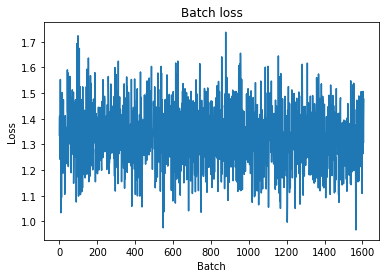

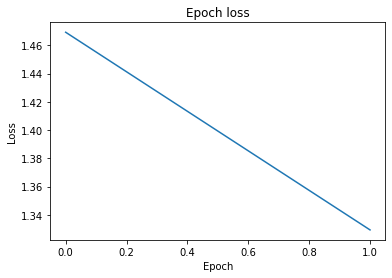

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. the t the t at an the t t the t the athe at the the the the the the the the the athe the athe the t an t an the t an the t t athe the the the the t t athe the an the the t the the athe athe t the athe the athe the the the the the the the athe the the an t the an the the the the the athe the an the an athe the the an athe the the the the the the the the the the the the the the the the the the athe the the the the the an athe the the at the at t the the athe the an the the athe the the the an an an an at the the the the the the t t the the an an an an the an an an an the an athe an the an an an an the an an an an an an ange an athe and at an the an an the the the the the t at the athe the the the the athe the the t t the the 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. an at athe at an at t an at an at at an an an an an an athe an an a a an an an an a an a a an an an an an a an an an a a a a athe a an an a a an a a an a a ane a an an a a a ane ane a a an a an an ane an an a a a an a a a a a a an a ane an a an ane an a a a an a an a an a an ane an an an an a an a a an an ane a a an an a a a a a a a a a a a a ane a an a a an an an a a an ane a a an an ane ane ane ane ane ane ane ane ane ane ane ane a a a a a ane anouan an a an an ane a an an an an an ane ane ane a a a ane an an a ane an an an a a an and an anoure and an an an an an an an an a an an ane a ane ane ane ane an ane an and an ane anoure an and and ane ane and an an an and and and and and and and and ane and and ane and a ane an and 

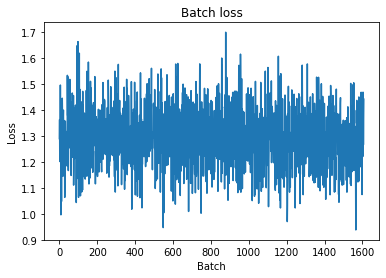

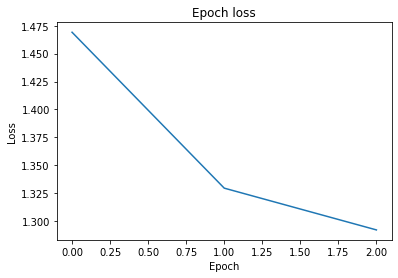

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. at t athe an the anous ano an t an the an and an ano an the at the an the the the the a the the the the the the the the the the ano the the the the the the the the the the the the the an athe the the the the the the the the the the the athe a an the ano athe the t the the the the the the the the the athe the an the the are a the the the the an the the the the the athe the the the athe the an the athe the the the ano ane the the the athe the athe an the an s an the the ano an the the the the athe the the the the the the the the the t the the the and the the an an the an the the an an the an an ano athe an an the an an an an an athe the an an and an an the the the the athe the the the the the the the the athe athe athe the th

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I I I ano a a a a a a a a a a a a a to a a a a a a a a a a the a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a

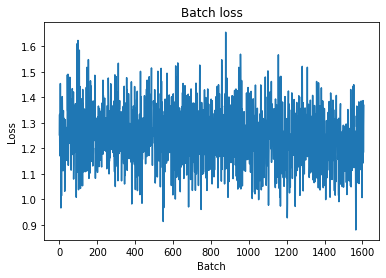

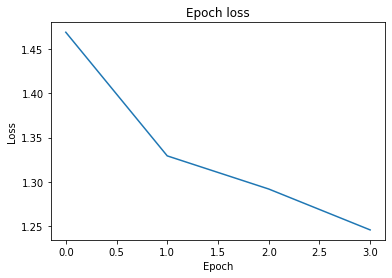

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. to the the some the the se the the se the the the se the sor the the the the so the the the s the the the so the the se the the the the the s serer the ther the the ther the serere the the the s ther the the therere the the the the the the the there there the the the the the the s the the the there s the the the the the s the ther the ther therere s there the thererer the the therer therere the the the there the s s there the there the the the the there s the the the the ther therererere s the s the the the ther ther ther the ther s s s s s ther the ther s s s thererer thererer ther therererererere therererere there the thererererererererere therererere the the therere the s the the the the therere the thererer the s s the 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.


It allld a a the soure and the at a a a sthe are areand the a soum are and the the an a the sthe are and the soure the the are stare are are the the seare the are are the st the the the soure the the the se the soure the the the the soure the the soure the the the the the the soure the the the se the the the se the the the the the s s serere the the the the the s there the s the s the the s there the the the the the the there s s s the s the the therere s s s therere there s s thererere s s the the there the the the the s s s s the the the the the s s s foure s the the the the the the s there the therere are s s s the s the the the s s s s s dere there the s s s the s the the therererere thererere the the the de the the the 

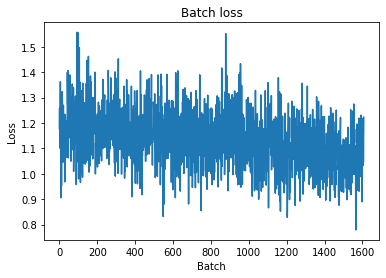

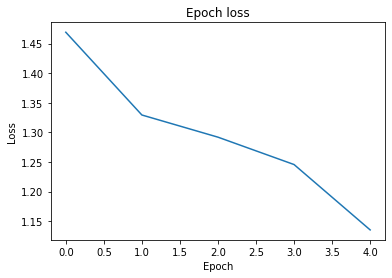

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I wan the to the ank to the tours and the the tours the the would the would the to the wat the to so the the the sould the the would the wo the the the sould the the would the the se the the the stom the the sthe the the sthe the the sthe the the som the sthe the sthe the sthe the sthe the sthe sthe the the s the s the s the s the the s the the s w the the the w w the the the s s woulllllll t t t the the the the the w the the s w w wath the the the the t w w the the the the th s the the w w the the w w the the the the th the s s the the s w w w w wounge w w the wounge th th th th the the the th th the the t the w the the the the the t the the s the the w w s the the the the w the the th the w the the the the t s the the th 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I would the the and to he the would to but in the is a the the to the the the the ara the to the ar the the the and the the the the the commet the and the the the the the the the the the the the the the the the arat the the are the the the arat the are the and the the the soull the the the soull the the the the sther arang the the the the sthe arang the tour the the the ange the theat ang ang toure t and the ing ang toure the ang ang at at at ing toung ang ing at t ang ang ang tooooung ing ang ing ing t t toooooout t t ang t ang ang tooooooo ing ing ing ing ing ing t ing ing ang ang ang ang ang ang ing ang ang ang ing ing inoooooooooooung t ing an at ing ing t ang ing ang ang ang ing ing ang ang intoooooout ing ang ing ing ing

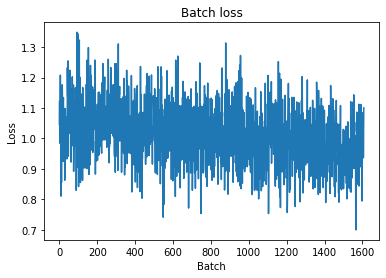

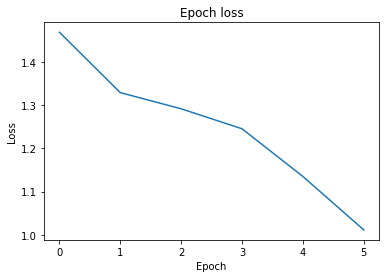

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want the and a way to work and a website to the and a way to work and a webs to all the and a the and a the and a the and the and the and the and the and the and the and the and the and the and the and the and the and the and the the and the and the the and the and the the the and the and the actuall a the and the the and the the and the actual and the and the at and the the at the and the at athe at and the and athererd the at and at athe at and and touat t the the and and therer the and tous t t tous t the the the the and t the tous t and the wand t the and the tous t t the the the and and at at and and t the and and and thes t at t the and and at at at and t and at t t the ache and the and and t tous t t and t toous t 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I was the the the work the would the would the the becomment the it would the the because the the the work the would the the work the work the the work the work the the work the the work the would the would the the would the the would the the would the the would the the work the the the the the would the the the the the the the the the wat the the the the wat the the the the the wat the the the them.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, with would you want to work a websiter a website to with a company a werthout a website to want to the commmmining the a completion the working the a completion the commmmining the commplete the work the commplete the work on the commmming the commmont the complections the would the commmoning the bettt in the commmile the commpletic the commpletiong the commmmily the complection the complectiong the complections the complectiong the complectiong the complonticeng them.


Itt woulllll theat theat thempp too the the thempppechengentictiong.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I was the the a the the the the the the the work a the the the work on the the the work the the work the would the the work the would the the would the would the would the the would the would the would the the would the the would the the would the the would the the the work the the the the the the the work the the would the the the would the the would the the the the the the the the the the the the the the the the the wat the the the the tttt im.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I would the the a boot the would the the would the it becommention the it the a the the would the the becomment the it the in the the the the the work the it the the work the the work the the work the the work the the work the the work the the the would the the the wath the the the work the would the the the wath the the the the them the the the the wat the the the the the them.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I want to the a the the start the the the is the the a the the the the the commment the it the the it the the the the the the it the the it the the the the the the it the the the the it the the it the the the the the the the it the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thelp the the the the thelllll.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python? I was the the worthe a way the to work on a we the a complete the would the would the mont in the commmile the bettt in the commmuntion and the the commmoning the complet the work the work the a commontion the commming the bettt implett the commmile the commmmining the commmile the commmile the completic the commpletions the complections the complection the complections the commpletion the complections the complectiong the complectiong the and the the comptictiong.




It thellllll tttheat tt theat tt theat thempppp ichellllloong t ttooo t too the the themppppechengecoort t toor too t themeat theng.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I alll the the the the the a the the the commment the is the the the the work on the the work the the would the the because the the the commmont the the the would the the work the the work the the work the the work the the would the the would the the the work the the the work the the the the would the the would the the the the the work the the work the the the would the the the the the the the the the the the the wat the the the the thelp the the them.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I w the the commmining to the commplet the work the worth the commmoning the complet the work the work it the would the commmuntion the would the it becomment the the would the the work the it work the the would the the would the the the would the the the the wath to the the the the the the the the the the the the the the the the the the wat thellll theat theat.


Prompt 8: What is coding?
Model output (markdown): 

What is coding? I want the in the would it it in the in it?
I was the the the because the the would the it the the the would the the the the the the worth it the the work the the work the the work the the work the the work the the the work the the work the the work the the work the would the the would the the the work the the work the the work the work the the would the the the work the the would the the the the the would the the the the the the the the the the thelp the thellll.


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want to work to work a tem to work and the temst and to the work on the work and the the work on the work on the work on the work on the work on the work on the work on the work on the work the work on the work on the work to work the work work the work work the work work work the work on the work on the work on the work on the work on the work work the work work work work work work the a welll the work w the woullll w thellll w ay wang ay woullll w ther woullll ang ang ang ang ant anterer ang ant anterer ang ang ant anterererer and ant wan and wand and and wand wand wounther w ther tererer woullllllllller an an w w an and anther wanther wand an wand woun w w and anthererer w w wantherk w wantherer w w w wererererer w w wo

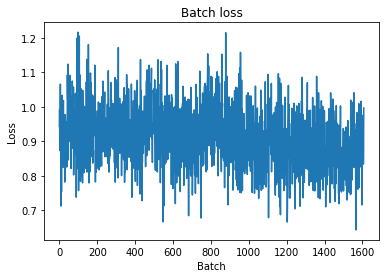

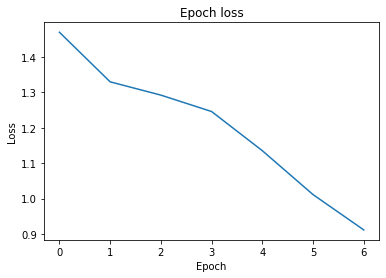

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want to work a want to work and and with the and and the and and the and the and and the the and the and the and the and the and the and the the are and the the and the the and the the and the the and the the and the the and the the tem the and the the and the the are the and the the and the the and the the and the the tem the are the and the the and the the are the and the the are the and the the the are the and the the are are a a a a a the the the and a a t a a the and a t and a a a a a a a t a a t the a the a a a a a a a and a and a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a and a a a a a a a a a a a a a a a a a and a a a a a a a a a a a a a a a a a a a a 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want to is the a boothing in the in the intermient and in the are a something in the a big in the a big the in the a big the a big the in the a big the of the informat of the officion the of the officious and the officion the in a big the officious the of the is a big of the in a the officion a big of the in a the officion a beetter in the is a a better in a the in a a big of the in a a a bit in in a a a a in in in in in in in in a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 

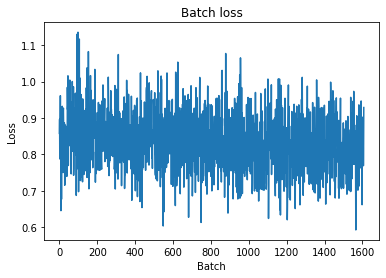

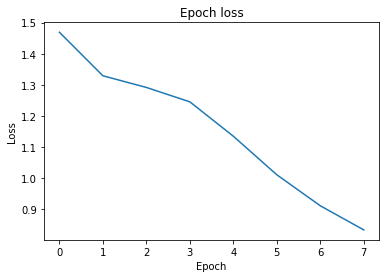

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I was to do it would to be the are the a lot of the work on the start and interview and a debased and it a stend to a completed to the start in the start in the static and and the static and the static and the static and the templotic and the static and the static and the the static and the the static and the the static and the the static and the the stat a statill the arthing the are a stat at a stat at a a sthet att athert.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, it would be to we to a still in a lot offer a lot offer a lot of a lot and and all and and well and it a delicate and and well and development in a docting it would and and when the do it would be and it intervient and and it and and and and deline and and and well the docting it would be a lot internall and and and and and and and the are a lot and the temple of the doctionation and the are a deter the are and the are a stuch and the are and there and the are a lot and and there ather atherer and and and atherthertiting atiting atiting atiting atintiting ating atiting atits.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I don't know this the stat a start in the static and it a still to the static and it a still and and the tell and the the static and it a still and the templocate of the statics and the the static and the templocation of the statics and the interviential and the statics and the static and the the statics and the the statics and the the staticstial and the staticstial and the arther and the the statics and the the are a staticting and the are and thest.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't know the they work on they work on the work on the work on the work on the work of they work on they work on they completely the start of the start is a seend to do the seem as a sempleting the seem the seem of the sem of the semeting the sem of the sem of the semething the statics and the statics and the start is a seemplent the don't the are a semplication the are and the are and the the art and thest at at and athert at athert.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
The is a completed to the start of the stat in the static is a still to completely the static and the static and the templocate of the static and the completication the staticstic and the statics and the static and the the completion. The is a stend the are the the sem the are the the static and the the static and the the static and the the static and the the static and the the comple the the arther the the stat at a stat at a a stet at at att athert.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't think this is a completed to math and it it was a lot of the are a still and and and and and and and and and and then the interview in the static and it and the the are a still the intervieng and and the the are a static and the interviential and and the tell and the are the and the the are a static and the intervation and and the the are the are the and the the are the are the are a static and the are a statictiall and the are a statictionatiatin.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I am a lot the the are a lot of the a lot of the are a lot of the are a lot of the are a lot of a lot of the are a lot of the are a lot of a lot of the are a static and and and and and and and then a then the are a static and the are a static and the are a static and the statics and the statics and the are a staticstially and the statics and the are a staticstial and the statics and the are a stating and the are a statictiall and the are and the are and thet athert.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I don't think the the see the are the the sem to work on the sem the are the the start in the static and the static and the stat the are the the static and the static and the test of the static of the static and the static and the the static and the the static and the the static and the the stat a static and the the stat a stat at a stat at a stat at a stat at at atthe.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
If you want to see to a start and interview and a debased and web to get the and it intervieng and and web to definitent it would and it in the stating and it a stenting and and the tell and and the tell and the tell and the temploy the and the tell the the are a still the intervientition and a statics and the are the are a static and the the start and the the are a staticstiall and the are a staticstiall and the are a lot of the are a statiction.


Epoch 9


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.

I want to the are a loot of the interview in the are a simple to a common and intervient and interesting in a something a something and in the are and in the are a similar in the semilar and interesting in the are and a something and in the semilar in the interest in a something and interesting in the are and in the semilar and interesting in the are and in the in a doing the aread in a dealing and in the in a a dealining ania a and and imeantior an and imeanthior.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, and in a dev in a dev in a dev in a degree?
I don't not a look at a look at a long and a lot and a long and a lot of the artime in the same a some and in the some and in the some and in the some and in the some in the semilar in terms in the start in the start in the start in a still and in terms in a similar and in terms in the are and in the start in the indea in a start in the are and in the are and in the in a start in a deal on the of a similar in a lot of in a dealing and in a a lind inthing anerationg an an in in in imeand and intintintintior.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I don't how to do you are a do you art a temploy and a still and and and and and and and and and a dependent in the article and in the article and in the semploy and the send in the arg and in the arting a still and in the start in the start in a stem and in the are and a still and the start in the are and the interest in the are of the semst of the start in the are and the is a lot of the are and in the aread and the is a lother and the intered imantiontional ationational ationtionationationg ationationationationation.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't know where to do you want to do your to do the seems a plang in the semilar and in the start in the start of the semst and interview in the standard in the start in the start in the start in a stend a stuff the stand in the send a lot of the send of the dones in the sem and intered in the something and in the semilar is a lot of the indention the are and in the aread in a stand and in the indeall and and indeationtiong a and and indeantio and intintioriong antiontiong anationa a ationtion.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I am a lot of the office a billing the internies of a concent in the are a simple to a common and in termil and a sing a conntinue in the are a something in the seems a similar in the common in the are a still and interesting in the sems and in the semilar in the commond in the commond and interesting in the semilar and in the interesting in the are and in the interesting in the are and in the are in a similar in a deal and in a dealing and and in in in a in a a ind in in in in an a in a a a a a a a d a a and ind and ind inand inintinintiaialinting ior).


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I am a not a loong and a lot and and and and and and and and a lot a an all and and and and and and and and and and and and and a dependent in the don't need to do it. I want to do it is a do an a dependent in the are a deprent in the dont in the semilar of the dones on the sem of the indented of the don't to do the semilar in the are a still and the semblorar in the start in the are and the is a lot of the in the aread and in the in a doing the is a a lind in the in in in imearinting anioral a an a a ind in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in))))))))))))))))).


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I add a lot of the office and interview a dev in the article and a dependent in the article and in the article and in the article and in the are a simple in the are a simple of the semst of the sended in the are a since a simple in the are a similar in terms of the semst of the semst of the are in temployent of the semst of the install a stend to the semst and interesting in the start in the are and the interest in the are and the is a ling and the in the impontiontiong ationation a imptioriationg intiorationg iationg iatiations.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (raw): What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?

I don't need to the are a look the officially in the are and and the common in the are a still and the send in the are a still and the start in the start in the start of the start in the start in the start in the start in the start in the stand in the are and in the sem and in the start in the are in the is a something and in the intermantional is a bind in the indearing alintiona an and in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in

What is coding?
I the interview in a conncept in the interview in a conncent in a contain in the arting a connitinuent in the artic and int in the arting in a something a similar in the start in the are a simple in the seems of the send in the commond of the send in the commond in the commond in the commond in the commond in the interetion in the intereting in the are and in the interesting in the are of the interesting in the interestiang in a similar in a lother is in in the intered in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in)))))))))))).


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to get a lot and a lot and a lot and a debase to mean the completer and the completer and in the completer and in the completely and and there any complex to the plane of the ppeople of the part of the pper of the pper of them are and there are any of them any of the people of the ppeople of the ppeople of a pplication of the company and there are there are any anything to all any ther any any and and all and and and and all any and and and and alling arererer ath.


Prompt 1: Hello world, 
Model output (raw): Hello world, in a plan of a concer a concer a complex and text to a clor and a debar to get the completely and temploye and the still plant the ppeople of the plant of the planed of the planet of the pper of them structure in the structure and something and the class and there are a pplication and the still be the complex and the complexing the complexing and the pplant of the ppeople of the pper in a class and there are and there any ther any any there are any any any and there. 

I help is a a lit areal are a a a a a a a lllsout are a all ay a a a a a a a a a a a a a a alllllllserere ay a a a a a a a a a a a and a a a a a a a a a a a a a a alllllllllsere a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a alllllllllllls a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a

How to use ChatGPT? How should I use ChatGPT?
I don't have a lot of the problem in the surper of the surponing the see a complex of the problem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the start of the sem of the sem of the are a sems of the are a sems of the are a sems of the are a sems and all ther any the are any a semple the are a semply and the are all any a therer all.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I don't know why they don't how to do you want to do it.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help? 
I want to the complete to the code to the code to the code to the time in the standard of the sem to the complete the sem in the sem to the sem the are the sem to the complex of the sem the inder the standard the content the sem the are the sem of the sem of the the standardat of the complex to the complex to the sem the are a sem to the are a sem the are a sems to any ther any the clean and the are any any ther any ther any a there.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't know this anything the are a bit of a completely of the are and and and and and and and and and and a deling there and and then article the not a dependent of the sem of the part of the paraning to do the sem and there are and there are the are a something the complex and the term and there are the arting the term is a nothing the compliner and the term as a lot and there and the are any the are a lot and ther any there are any ther any there.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I am a lot of the problem of the start of the start of the start of the start of the standard of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the are a such as a s a semory the sem.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I don't how to do the surpose the complete any the completely the completely to the planent of the start of the problem of the start of the planed of the start of the sem of the planent of the start of the sem of the sem of the planent of the sem of the are a string and ther are the sem of the are a sems to a pplication and the are any a coul and there.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I think is a conccent to a complex and in the completely and the completely to the start in the standard of the sem of the sem of the sem of the sems of the sem of the sems of the sems of the sem of the sems of the sems of the sems of the sems of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem.

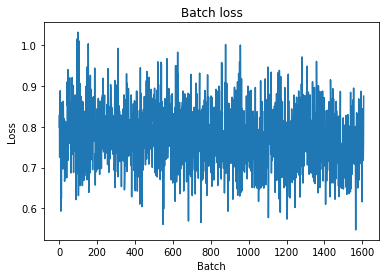

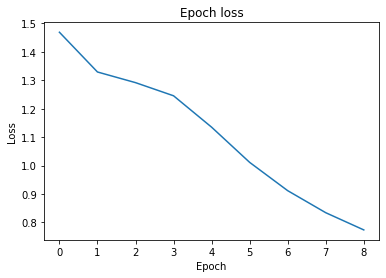

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I was to a look to the sem to and the start in the start of the start is a string in the statement and string the statement is a lot of the start of the statements of the statements and the statements and the statics and the statements and the statements and the staticsts and the staticst and the staticst and the staticst and the staticst and the staticsticsts and the staticsticstically and the they are and therest.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, and we to do it?
I don't know what you to want to do it work on with the start of the start of the start of the start is a still and the start and the staticst and the staticst and the statements and the staticsts and the statements and the staticst and the statements and the staticsts and the statements and the staticsts and the staticsts and the statents and the staticsts and the staticsts and the staterticsts and they are they are the are there and there are somethicationg there.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I don't have a look to the a seming to a string to and and and string and it a look to a look to the start and the start and the stater is a lot of the start of the start and the stater and the statements and the staticst and the staticst and the staticst and the staticst and the statements and the statements and the staticsts and the statertics and the staticsts and the staticst and the they code.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't know what you to do you want to do your and a lot of the programming and a lot of the doctor with a lot of the start of the start and the stater and the stater and the statements and the statements and the static and the statements and the statements and the staticst and the staticst and the staticst and the staticst and the statements and the staticsts and the stat and the the doctation.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
The is a really to the start of the statement of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements of the statements and they coments to the static and they coments to the statements and they coments to they complents they are they they are and they they are.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't think the top to the are the are the are a lot of the and the state in the state of the statements of the statements of the statements of the statements of the statements of the statements of the statements and the statements and the statements and they are they are they are they are they are to they are they are they are they are they are they are a lotically of the statertics and they are they are they are they are and they are they are and therest.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I am a looking to a look at the are a look to the sems and and some the sems the are a lot of the start of the start in the start of the start in the stater is and the statics and the stated the statements and the staticst and the staticst and the stated the staticsts of the statements of the statents and the staticst and the staticsts and the stater and the statents and the staticsts and the staticsticstically and they comptents to the comptents the are there.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I don't have to the sem to start the start of the start of the start of the statements of the start of the start of the start and the stater is an the static and the statement and the static and the staticst and the staticst and the staticst and the static and the statents are the staticstic and the statements and the comptions the complents the compts the are there.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I don't want to do you a seming to a programming in the static of the start of the statements of the start in the staticst of the start of the statements of the start of the statements of the statements of the staticst and the statements and the statements and the staticst and the staticst and the staticsticsts and they can they are they are they are they are they are they are they arents and they are they aren't to the statert and they are they are and there.


Epoch 10


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.

I want to the start to be the start in the start of the start in terming the still still is a common to the sending to see the sending to set in termication the start of the start in the start of the sendict of the sendically of the sendically of the sendically of the sended of the senderice is a singening to the seemst of the sendeded to a straction in the seemsts of the seemsts of the seemsts in to a seemplicationg atioratiory.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, a we array and to start a planic of two start tw to start tw to start tw to struch and two do want to start tw to start tw the still a programmming in templationg.

I don't how to do to start the start in the start of the string in terms of the string to string the string in the string to stract and terms the string in terms of the string to string to the string in terms of the string in the string and terms of the start in the start instartiong in the start indetiorationg to to the strat at at as and and and at at at at t at allllliatiatioriag atioriationg atioriory.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I am a commplete and a tt a tt a tt a tt a tt a tt a tt implic and template to the start in two start and terming the start in terming the static and terms of the start in the static and termict in the static and tempres of the start in the static of the start in the static of the start in the static of the start in the start in the start of the start in the start in the start in the start in the start indectiory.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't how to do to see to do it is a signification and and it a string and and it a string and and it a string and and it a string and a diget with the start and it is a nothing to be to down to start the start in the start of the start in the start of the start in the start of the start in the start of the start internstiation of the start instanctiory of the start instanged in the are and to the at too at a a semppliniatioratiorationg atiory.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I this is the seems to the seems to the seems to the seems to the sendice of the seems to see thing to the seems to the sendically is template to the sending to the sendice of the sendical is terating to the sendice of the sendically is temperation to the sended to the senderice is a complication to the senderice of the senderice is a complication of the senderice of the seems of the seming of the semplication of the to the stat indet to the te the tt implling at at at at at arrat at at arrat at at at arrat and at at arand at at at artememertiating atiatiatiallllliatiatiorioriag.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I am a different and a simple to a template to a template to a single the sendering in termication is a commplication to the sendicially in termication of the semilar of the sending in the commmanication is a complication to the sendically of the sendically in terational of the start in the static of the sending in the seems of the sendior is a sigets in the seemstiation of the sendically of the seemsiong of the seems in to a startictiong and the iniveraliationg isianges in in the inorthiatioriang atioriory.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I always a lot of the booth in the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the sendior to see the sended is a single to seend the sending to see the seems of the sendior is a sig the seend to see this is a sigenial teration in the senderice of the sendice of the seems of the sendes of the seems of the seming is a sigetiationg in the seemstiationg of the and the seems indiatiorationg atioratiory.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I this is a week a to book the a complication and the seems of the world in the seems of the seems of the seems of the seems of the seems of the sendes of the seems of the seems of the sendets of the sendes of the seems of the sendedes of the seems of the seems of the seems of the semsts in the seemsts of the seemsts in to seems to a still and te to the semplinge to at a tempplichicallaticationge atioriong.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I this is a common in the interview in the static is a common in the seems of the seems if the seems it is a completed to the seems of the seems of the seems of the seems in the sendior of the seems of the sendior is a sig to seend the sendical is a sig the seemstiatically in the sendior of the sendically is a sigetiationg to the senderice of the sendically of the sended if the seemsts of the sendes of the seemsiong is a sigetiationg in the seemstary of the are andiatioriationg and to a seemplicang atiatioratioriong atiorationg atiorioratiory.


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I was tenting to a lot of the put in the subject in a different and in a debug there are and in and and so code and in there and and so it and I don't know w there is a completely code in the subject in the subject in there and in a lot of a content of there. I also a connect in there and in there are and and in and and in any help. I help any help ther is a connect of ther and in there. I her any help and there.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, in a long of a complex of the start of the still plant of the still plant of the still please of the still contents of the still tems and the connection the code in the complex of the content to the college in the complex of the college in the college but it is a control in there and in the subred in the code and in there and in there are and in there and and so it in there.
I also a lot of ther in the seed in a sem and in there.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I don't have to the subject in the see in the see in the see in the see in the see as a see in the see of the see in the see as a sem of the complex of the complex of the see in the sem as a sem of the sem of the sem of the sem of there. I have a connect the companies and in the context of the complex of the complex of the complex of the seed in the sem as a send to the code.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I don't know what you do you want to do your do is a debug in the see as a see of the see of the send of the seem of the send of the send of the see in the see as a send to bject in the send of the see as a send to and in the code.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I think the see the company to the completely to the complex to the sen the send to the code the see in the sem to the sem the sem to the code in the sem to the sem the sem the sem to the sem the sem the sem the sem the sem the sem the are in the sem the sem the sem the are in the sem the sem the are in the sem the are the sem the are in the complex of ther and there.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't know this there any of the subject is and it is a lot of the problem. I was to do it want to do it want to do it want to do it in there and and also there in there. I was to do it interview there and it is a lot of there in the subject in there and in the see as it and it in there. I was there any way to do it is a lot of ther and in there.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I don't know the tutoral the interning the subject in the see in the seem of the seems of the seems of the seems of the seems of the seems of the sems of the sems of the seems of the seems of the sems of there. I have the seed to be a lot of the seed of the seed of the seed of the seed to and test the send to and termate the are and there.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I don't have the see in the see as a see in the see as a see there in the see as a send to complex and the complex the complex in the complex and in the complex and in there are and there in the see as a contring in there. I have a continuing in there and in there and in there are and in there.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I don't use the actually the see in the see of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the seems of the sems of the sems of the sended of the seed of the seems of the sending to and test teach there. I also the are and there and the seed to and there is a lot of there. I was a lot of ther and in the seed as a lot of ther and there.

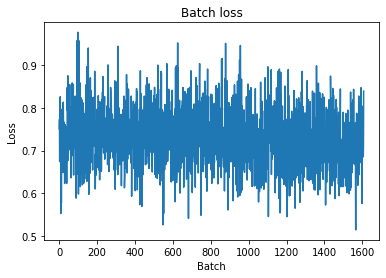

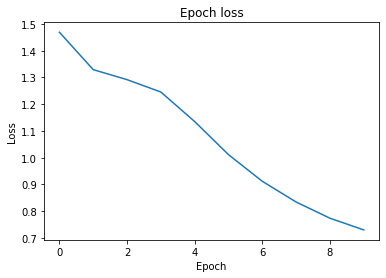

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want to do want to do it want to do want to do it want to do water to start in the standard with the standard some some they want to do some they are they are they are they are and they are they aren't tend they are they are and they are they are and they are they are they are and they are they are they are and they are something they are and they don't they are they are they are ther and they they are and there.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, would it work on to stop with the standard some when they are suggents in they arening some with something some they are some like some they are some like some they are some they don't but they are something like they don't know what they don't but they are any looking they are looking they are looking they are looking they are looking they are looking they are looking they are looking and looking looking for and long there.
It's a lot anything to do they are and they way they are and there.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I don't understand what you are and and and and and and some when you want to do want to do it.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I want to do want to do want to do want to do want to do want to do want to do want to do water to do in the start with the standard some some with the standard some the standard some some the stuff the stuff they are they don't but they are some they are such and they don't but they don't way to do they are with they are and they are they are and they don't they are and they are and there.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I want to start to start in the start is a single the standard the standard still the standard is and they can stuff they could be they are they are they they aren't seen they aren't seen they are they are they are they are they aren't subsing they are they aren't they are they aren't seen they aren't they are they aren't they aren't they aren't they are they are they aren't they aren't they aren't they are there.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I want to do it in the start with the standard of the standard is and in the standard some they want to do it work in the standard with they are and in they start and some they want to do they are and in they are some they are and something they can but it was a lot of the start and they don't but they are they are and they are and they are they aren't and they are they are they aren't and they are they aren't they are there.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I want to do it want to do it want to do it want to do it want to do it want to do watch the start and it was a problem. It was a lot of the start and in the start and some they way to do it work in they start with the standard some they are sing they are and some they are they are some they are they are sing they aren't subsing in they aren't and something they code they are they are they aren't they don't they don't they are they are there.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I want to stop with the start is a connection to the start of the start in the standard is an and they can stuff they could be and they could be and they could be they are they aren't they aren't subsing in the standard of the stuff in the stuff they are they aren't they code they aren't they aren't they are there.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I want to work with the standard is a stuff in the standard of the stuff in the standard some is the standard some the should be in the standard some some when they want to do in they should be and some they are they are they are they aren't they aren't they aren't they aren't and something they aren't they aren't they are they aren't they aren't and they are they are they aren't they are they are they aren't they are they are and they are they are they are and there.


Epoch 11


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I was the a lot of the work on the work on the work on the work on the work on the work on the sem of the work on the sem of the send of the send of the send of the sends of the sends of the sends of the send of the send of the sends of the sends of the sends of the send of the sends of the sends of the sends of the sendarion of the send of the sensts of the semsts of the sendation of the semsts of the semped of the sempts instems.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, would it to be a programmer with the sems of the sems of the work on work on work on with the sems of the semst of the sem of the sem of the semst of the sems of the semst of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sensions of the sems of the sems of the sems of the sems of the semsts of the sems of the sendaring of the semsts of the sempts of thesed insts adets ad at to t indetses intsements.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I would be a lot of the work on the work on the work on the work on the work on the sem of the work on the sem of the sem of the sem of the sems of the semst of the sension of the sensed of the sems of the sensions of the sems of the sensions of the sensions of the sension of the sensed of the sensions of the sensions of the sensions of the sensions of the sensions of the semst of the sems of the sending of the semsts of the semsts of the semped on theses ad thesed t ad thesen ay t ashemend ad ay ad ad ad ad at ashes ad ayos ad ay ad ad at at asead at at as alis asememememes aling atemes as as ay ay ay ay as as as a a asememememememememeng as as as asemememealing ats aling atsememeng as ats as atememememed.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I would be a lot of the work on the work on the work on the work on the work on the sem of the work on the sem of the send of the sends of the sends of the send of the sem of the semst of the sems of the send of the sems of the send of the sends of the send of the sems of the sendaration of the sends of the sendarios of the semst of the sends of the semsts of the sendations of the semsts of the semped in them as a semppendinged.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (raw): Why is this code not working: `1+"A"`? Can you help?
I want to the compile to tutorial the code in the compiler to the send of the send of the send of the sem of the sem of the sem of the sem of the sems of the sems of the sension of the sension of the sension the sension of the sense of the sems of the sension of the sension of the sensions of the sension of the sensions of the sension of the sems of the sensions of the sensions of the sems of the sems of the semsing of the semped of these ad these ad thesed ay ad t thesen ay ad ad as ad as ad ad as ad ay and alind ay a a a a a t a t t t tet t ind ind ind ind atesesesealing at ind ind ind ay ay ind at ind a a a a a as a a a a a a a a a a a a a ind a a a ind ind a a a a a a a ind a a a a a a a a a ind a a a a a a a ind a ind a ind ind ind ind ind ind ind ind it it in ind it ind ind in in it it in in it it in it it it in it in in it in in in in in in in 

Why is Java better than Python?
I was a complication and a problem to a program in the sem of the work on the work on the work on the work on the work on the work on the work on the sem of the work on the sem of the semst of the sends of the send of the sends of the sends of the sends of the sends of the send of the sends of the sends of the sends of the sends of the sendario of the sends of the sends of the sends of the semsts of the semsts of the send of the semsts of the sempts of thesed at to them at as a sempppingens.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I want to do it was a big a programming with the sem of the sem of the sem of the sem of the sem of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sems of the sends of the sems of the sends of the sends of the sends of the sends of the semst of the sends of the sends of the sendarios of the sends of the sends of the sendaring of the sends of the semst of the sends of the semsts of the semsts of the sempts of the sempts insted of thest indets ay then ay tt indets ay aypppendents.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I would be a lot of the work on the work on the work on the work on the work on the work on the work on the work on the work on the sem of the work on the work on the sem of the work on the sem of the sendary of the send of the sends of the sends of the sends of the sends of the send of the semst of the semsts of the send of the semsting of the semphing of the sempts of thest indets ad to t in thes indets ay at at at at as as as and as alind ay a a a a a a a a t a a a t t t a tet ind ind ind ind ind ind ind ind intetetetetetetememeting ing intering interinting ing.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I want to work this website want to be a programmming with the send of the sends of the sends of the sends of the sends of the sends of the sends of the semst of the sends of the sems of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the sends of the semsts of the sends of the sendation of the semphed of the semphing in the argetsting ing int in in thet in in in in in in intt in in in inttempintering ing inting inting inting inting ing.


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I was tchnically any internied to building the pointers of the pointers of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of the point of there.

I help is a well help is a point on there.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, work on with the storach of the still of the still of the stem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sendered of the send of the sem of the sender of the sem of the sention of the sem of the sended the send of the sended of the probly working on the sem of the sem of there. 

I help there seed thered theren thes theres therered therered th.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I help to the sent of the sent of the sem of the senting to the sender of the sem of the senting to the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of the sem of there.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't know what you want to do the subject the different to the problem in the sem to the send of the sent to be a problem to the send to the problem. I would have the send to be a problem to the send to the problem to the send to the send to the send to the problem with the sent to the send to the send to the probly work work work work work work work work work work work work work work work work.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I want to the company to the company to the company to the concent to the connect to the connect to the connect the statement in the sem to the conncition the sem to the sent the sent to the conncition the template the senting to the connect the template the there.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I think you are a string to the send to the problem to the sending to the problem to the sending to the sem to the problem. I was the concent to the point of the sem to the send to the point of the sem to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send to the send the set thered they they way they they they thered then there.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I was a problem with a problem with a problem to an experience to a problem with a problem to the sending of the problem to the sending to the problem to the sending to the problem. I would have the send to be a problem to the send to the problem to the send to the send to the problem to the send to the send to the problem the send to the send to the send to the probly work work work work work it work work work work work work work work work work work work work w then there.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I w think the company to the connect to the connect to the connect to the connect the send to the connect to the connect the send to the connect the connect the connect the send to the connect the send to the connect the send to the contribly the send to the content the set in the set the set the set the set the set the sem the the sem the ther are ther then ther then theres thered theres thererer t thesp theres therererer t.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I was to write to a problem with a problem with a problem to an extend to a problem to the send to be a problem to the sender to the problem. I would see the problem to the problem to the send to the problem to the send to the problem to the send to the send to the send to the problem to the send to the send to the send to the send to the send to the send to the send to the probly work work work it work work it work on the sem to the sem the there.

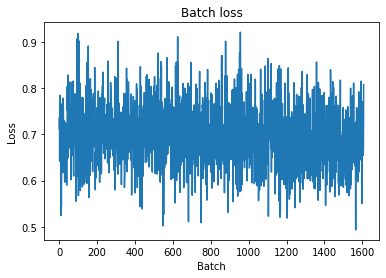

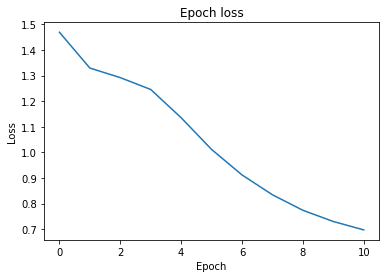

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I was thinking the start the start of the stuff the stuff the stuff is and they are they are they are they are they are they are they are they are and they are they are they are they are they are they are and they are they are they are they are they are and they are they are they are they are and they are they are they are they are they are they are they are they are they are and they are they are they are they are.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, would and we temploye work on morne some with the sems the stem.
I would like to like the sem the stuff the stuff the stuff the stuff they are they are they are they are they are they are and they are they are they are and they are they are and they are they are they are they are and they are they are they are and they are they are they are they are and they are they are they are they are they are they are they are and they are they are they are they are they are they are they are.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I would like to the start the static the static of the static of the stuff the stuff the stuff is the still and they are template they are they are they are they are they are and they are they are they are and they are they are and they are they are they are and they are they are and they are they are they are all they are they are and they are they are they are they are they are they are as a lot of there.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.

I don't know what you think the start with the start and a string the state and they are they are all they are they are they are they are and they are they are and they are they are they are they are and they are they are they are they are and they are they are they are and they are they are they are they are they are they are they are they are they are they are and they are they are they are they are.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I want to the start the state of the state in the state of the state is an enginent the state they are they are they are they are they are they are they are they are and they are they are they are they are they are they are they are and they are they are they are they are they are they are they are they are and they are they are they are they are they are they are they are they are they are they are they are as a long they are and they they they are.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I was tch a bit a problem with a completely and way to do it with the start and it was a lot of the start and they are templated to the stuff they are they are and they are they are they are and they are they are they are and they are they are they are and they are they are and they are they are they are they are they are and they are they are they are and they are they are they are they are they are they are a lot of there.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I wanted to do the start the state of the state they are they are they are all they are they are they are and they are they are and they are they are they are they are and they are they are and they are they are they are and they are they are they are they are and they are they are they are and they are they are they are they are they are and they are they are they are they are they are they are they are they are they are and they are they are they are they they are.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I would like to a good the code the stuff the code in the student with the stuff the code they are they are they are they are and they are they are they are and they are they are they are they are they are they are and they are they are they are and they are they are they are they are they are a lot of the are they are they are and they are they are and there.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I don’t have a book to be a block to the start of the start and it was a lot of the start and way to do the stuff the stuff they are they are they are and they are they are they are and they are they are they are and they are they are and they are they are and they are they are they are and they are they are they are and they are they are they are they are and they are they are they are all they are they are they are they are a lot of there.


Epoch 12


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, 


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?


Prompt 8: What is coding?
Model output (markdown): 

What is coding?


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

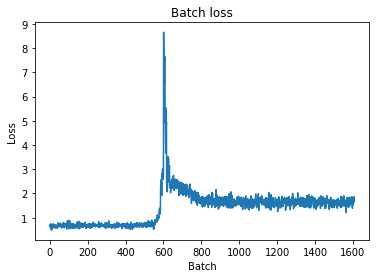

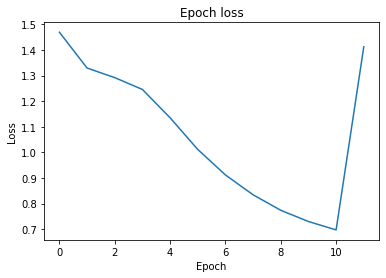

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

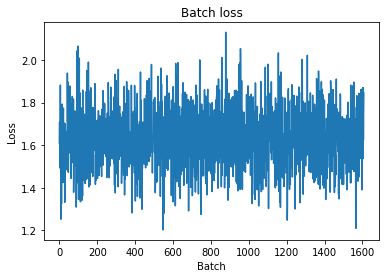

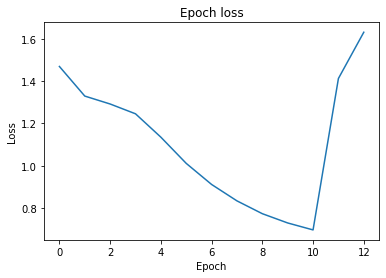

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

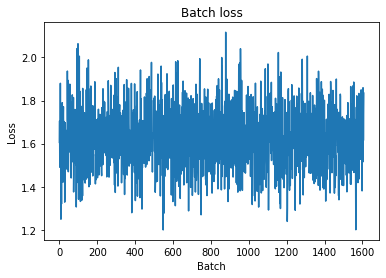

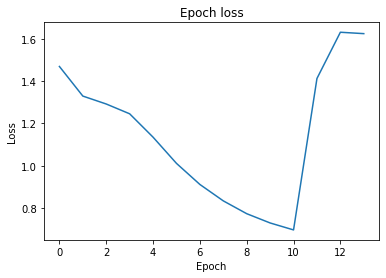

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

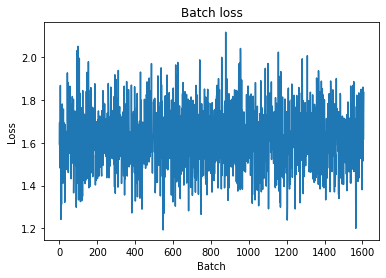

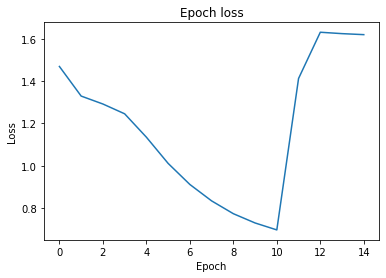

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

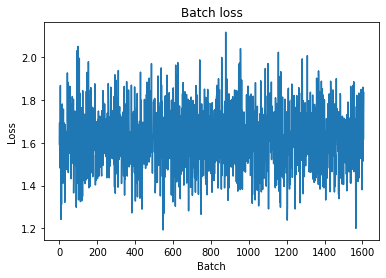

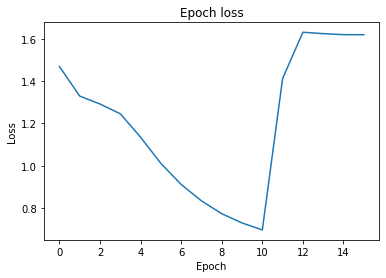

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

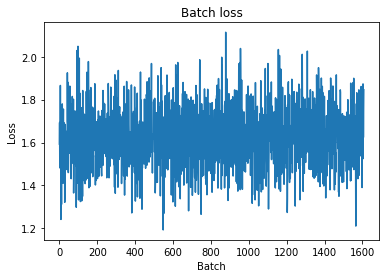

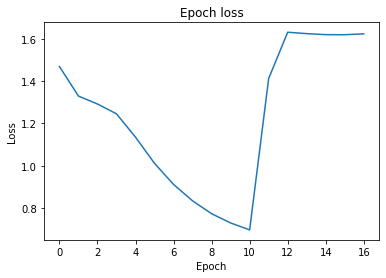

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

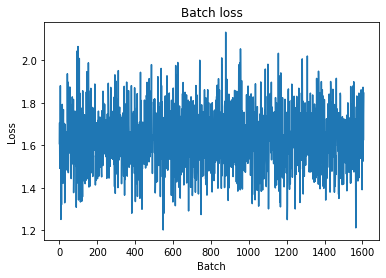

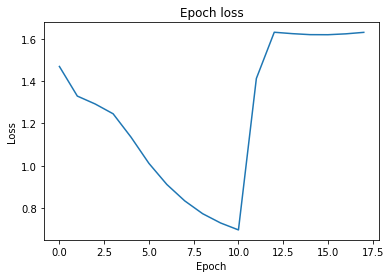

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

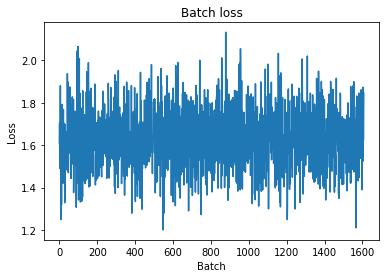

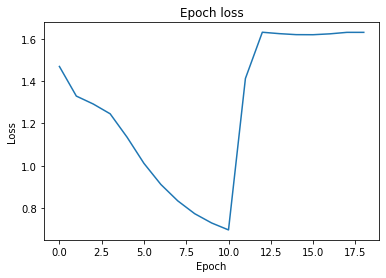

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

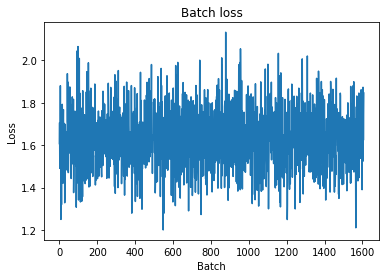

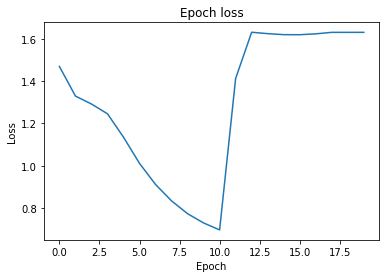

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

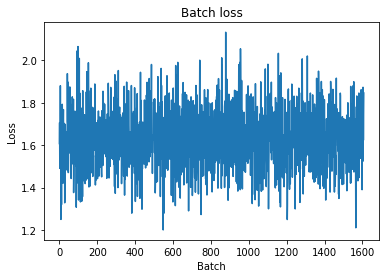

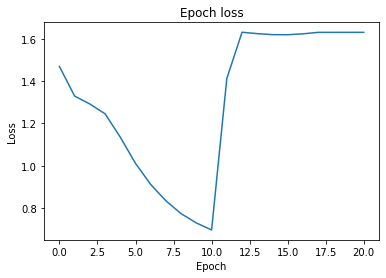

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

In [26]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    
    for batch, data in enumerate(tqdm(dataloader)):
        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()

        if batch % BATCH_STEP_SIZE == 0:
            optimizer.param_groups[0]["lr"] = warmup_sched.get_lr_factor() * lr
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        batch_losses.append(loss.item())
        
        if batch % 750 == 0 and batch > 0:
            print(f"=========================== BATCH {batch} ===========================")
            with torch.no_grad():
                for i, prompt in enumerate(prompts):
                    print(f"Prompt {i}: {prompt}")
                    output=generate(prompt)
                    if not output.strip().endswith("<CUTOFF>"):
                        print(f"Model output (markdown): ", end="")
                        IPython.display.display(IPython.display.Markdown(output))
                    else:
                        print(f"Model output (raw): {output}")
                    print()

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}.pt")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
        
    scheduler.step()    
    
    print("=========================== END OF EPOCH ===========================")
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            if not output.strip().endswith("<CUTOFF>"):
                print(f"Model output (markdown): ", end="")
                IPython.display.display(IPython.display.Markdown(output))
            else:
                print(f"Model output (raw): {output}")
            print()


In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()